In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/'DSAI Project'

/content/drive/My Drive/DSAI Project


In [ ]:
!ls


 catboost_info				 features.gdoc
'Copy of DSAI Project (Draft 3).ipynb'	'Mini Project.ipynb'
 data					 submission.csv
'DSAI Project (Draft 3).ipynb'		 train_df_final.csv
 EARTHQUAKE.ipynb


In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

from scipy import stats
from sklearn import preprocessing

# Visualization 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # remove runtime warning for more than 20 figures
import missingno as msn
#import seaborn as sns already imported as sb
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_values = pd.read_csv('data/train_values.csv')

In [ ]:
train_labels = pd.read_csv('data/train_labels.csv')

In [ ]:
test_values = pd.read_csv('data/test_values.csv')

In [ ]:
train_data = pd.merge(train_values,train_labels)

# EDA

We first want to explore the damage grade data to see the distribution of damage grades through counting the values for each damage grade and running a cat plot.

Number of damage grades: 3
2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


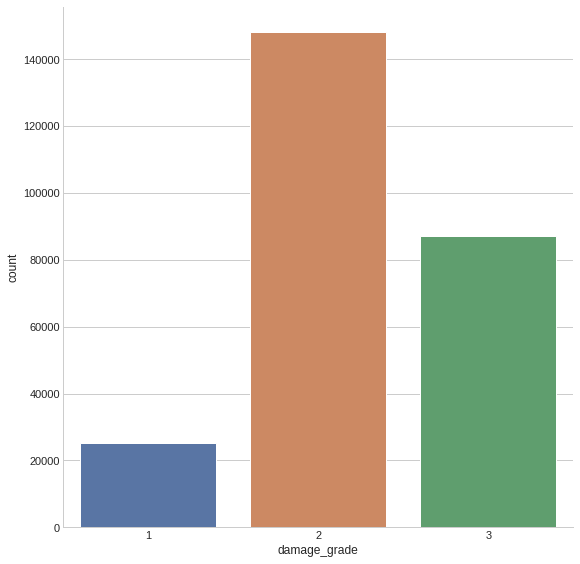

In [ ]:
#Damage grade in the Dataset
print("Number of damage grades:", len(train_data['damage_grade'].unique()))
print(train_data['damage_grade'].value_counts())

#Damage grade catplot
sb.catplot(x = 'damage_grade', data = train_data, kind = 'count', height = 8)

We also want to explore the data types of the variables to explore the different types of variables we have and if they coincide with the descriptions given in the problem description. As seen below, binary variables like the superstructure material columns and secondary use of building columns are of the integer data type, numerical variables like age, area percentage,height percentage, damage grade, building IDs and geo level IDs are of integer data type while categorical variables like land surface condition, foundation type, roof type, ground floor type, other floor type, position, plan configuration and legal ownership status are of object data type. 


In [ ]:
train_data.dtypes

building_id                                int64
geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_c

In [ ]:
train_data.head(n=5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


Upon looking at the train data, we realise that the distribution of values of the building ID and geo level ID variables were too wide to do meaningful analysis with using graphical plots, hence have decided to leave them out of further analysis.

In [ ]:
train_num = train_data[{'age','area_percentage','height_percentage','damage_grade'}]
train_num.head()

,age,area_percentage,damage_grade,height_percentage
0,30,6,3,5
1,10,8,2,7
2,10,5,3,5
3,10,6,2,5
4,30,8,3,9


We first explore the data by looking at the statistical description. As seen below, there are some variables, particularly the age of the buildings, that have particularly wide standard deviations, suggesting that there may be a wide range of values or some outliers. We will first do uni-variate analysis by plotting boxplots, kde and violin plot to further explore the data  

In [ ]:
train_num.describe()

,age,area_percentage,damage_grade,height_percentage
count,260601.000000,260601.000000,260601.000000,260601.000000
mean,26.535029,8.018051,2.238272,5.434365
std,73.565937,4.392231,0.611814,1.918418
min,0.000000,1.000000,1.000000,2.000000
25%,10.000000,5.000000,2.000000,4.000000
50%,15.000000,7.000000,2.000000,5.000000
75%,30.000000,9.000000,3.000000,6.000000
max,995.000000,100.000000,3.000000,32.000000


In [ ]:
# For loop for boxplot, kde, violinplot for each numerical variable
# Uni-variate analysis
for i in train_num.columns:
    if i != 'damage_grade':
        f, axes = plt.subplots(1,3,figsize= (16,8))
        sb.boxplot(x= i, data= train_num, orient = "h", ax = axes[0])
        sb.distplot(train_num[i], kde = True, ax = axes[1])
        sb.violinplot(train_num[i], ax = axes[2])

1.   Age:
Skewed towards the left, with majority less than 200 but with plenty of outliers (extreme outlier around 1000)
2.   Height_percentage:
Skewed towards the left, with majority around 5 but with plenty of outliers
3.   Count floors:
Majority are just 2's, with some in 1 or 3 and minority outliers beyond these three
4.   Area percentage:
Skewed towards the left, with majority around 0 to 20 but with plenty of outliers


We then do a bi-variate analysis against damage grade to view the variables in relation to it

In [ ]:
# Bi-variate analysis
# Joint boxplot for numerical against categorical data (damage_grade, the response variable)
for i in train_num.columns:
    if i != 'damage_grade':
        f,axes = plt.subplots(1,1, figsize=(16,8))
        sb.boxplot(x = i, y = "damage_grade", data = train_num, orient = "h")

1.   Age:
Skewed towards the left, slight relation between damage_grade and age since the figures are quite similar. Thus, not a good predictor.
All of them have an outlier around 1000
2.   Height_percentage:
Skewed towards the left, with majority around 5 but with plenty of outliers. Need to remove outliers for a more balanced data.
3.   Count floors:
Those with less than 2 are more likely to be in damage_grade 1, those greater than 2 are more likely to be in damage_grade 3.
4.   Area percentage:
Skewed towards the left, plenty of outliers. A slight relationship(?) since the figures are quite similar. Need to remove outliers for a more balanced data.

Since most of the variables have much outliers, we explore how many outliers there are and filter out those that are not within 3 standard deviations from the mean.

In [ ]:
# Finding number of outliers per column variable
for col in train_num.columns:
    if col != 'damage_grade':
        # Calculate the Quartiles and IQR for each numerical variable
        q1 = train_num[col].quantile(0.25)
        q3 = train_num[col].quantile(0.75)
        IQR = q3 - q1
        outliers = 0
        # Finding outlier for each numerical variable using for loop, then print
        for data in train_num[col]:
            if (data < (q1 - 1.5* IQR) or data > (q3 + 1.5*IQR)):
                outliers += 1
        print("Outliers in: \n",col,":",outliers, '\n')


In [ ]:
from scipy import stats
train_num_filtered = train_num[(np.abs(stats.zscore(train_num)) < 3).all(axis=1)]
train_num_filtered

Now, with the data filtered, we conduct the uni-variate and bi-variate analysis again to get a better idea of the data

In [ ]:
for i in train_num_filtered.columns:
    if i != 'damage_grade':
        f, axes = plt.subplots(1,3,figsize= (16,8))
        print (train_num_filtered[i].describe(), '\n')
        sb.boxplot(x= i, data= train_num_filtered, orient = "h", ax = axes[0])
        sb.distplot(train_num_filtered[i], kde = True, ax = axes[1])
        sb.violinplot(train_num_filtered[i], ax = axes[2])

The plots are now not as skewed, standard deviations are not as wide and distinctive shapes can now be seen. The variables height percentage and age percentage seem to have peaks and are somewhat symmetrical about the median, while the variable age, has a peak, followed by decreasing counts of values after that peak. There is no smooth KDE plot for the values, indicating that the values may be more distinct. There are also lesser outliers seen in the box plots, though there are still a number of them in age.

In [ ]:
for i in train_num_filtered.columns:
    if i != 'damage_grade':
        f,axes = plt.subplots(1,1, figsize=(16,8))
        sb.boxplot(x = i, y = "damage_grade", data = train_num_filtered, orient = "h")

While there are some distinctions in the values of these variables and the damage grades, there still appears to be no clear distinction, thus we will look at the correlation between the variables and the damage grade to get a clearer idea of what features are important in classifying if a building will receive the least damage possible during an earthquake. 

In [ ]:
corr_df = train_num.corr()

# Correlation matrix for train num data
sb.heatmap(corr_df, annot=True, linewidths=2, fmt= '.2f', cmap = "BuGn", vmin=-1, vmax=1)

Looking at the correlation of the variables with damage grade, there seems to be a low negative correlation of damage grade with area percentage, a low positive correlation with age and an even lower positive correlation with height percentage. This could indicate that these values are not very important to predicting the damage grade of buildings during an earthquake.

In [ ]:
corr_df0 = train_num_filtered.corr()

# Correlation matrix for train num data
sb.heatmap(corr_df0, annot=True, linewidths=2, fmt= '.2f', cmap = "BuGn", vmin=-1, vmax=1)

Now, we will move on to the analysis of categorical variables, non-inclusive of binary variables. We took out building ID as it was a random unique identifier of values. 

In [ ]:
train_cat = train_data.drop(columns = ['age','area_percentage','height_percentage'])
train_cat

In [ ]:
# Remove secondary use & building_id, not relevant as predictor to damage
secondary_use = train_cat[{'has_secondary_use','has_secondary_use_agriculture','has_secondary_use_hotel','has_secondary_use','has_secondary_use_rental','has_secondary_use_institution','has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other'}]
train_cat = train_cat.drop(columns = ['building_id','has_secondary_use','has_secondary_use_agriculture','has_secondary_use_hotel','has_secondary_use','has_secondary_use_rental','has_secondary_use_institution','has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other'])
train_cat

In [ ]:
for i in train_cat:
  train_cat[i]=train_cat[i].astype("category")
  print(train_cat[i].describe(), '\n')

We converted the data type of the objects to category and when analysing the data found that count floors and count families variables had distinctive values despite being numerical variables, thus converted them into categories

In [ ]:
# Converting certain numerical data type into categorical data type
count_floors = pd.DataFrame(train_cat['count_floors_pre_eq'])
count_floors = count_floors.astype("category")
print(count_floors.describe(), '\n')

count_families = pd.DataFrame(train_cat['count_families'])
count_families = count_families.astype("category")
print (count_families.describe())

In [ ]:
train_cat.dtypes()

In [ ]:
# Remove superstructure columns(binary) and adding the newly converted categorical data types
#train_cat_1 = train_cat.iloc[:,:10] #until plan config
#train_cat_2 = train_cat.iloc[:,21:] # legal ownership until damage_grade
#train_cat_final = train_cat_1.join(train_cat_2) 
#train_cat_final = train_cat_final.drop(columns = 'count_families', axis =1) #remove old numerical type
#train_cat_final = pd.concat([train_cat_final,count_floors.reindex(index=train_cat_final.index),count_families.reindex(index=train_cat_final.index)], axis=1)

In [ ]:
train_cat_final = train_cat

We then started our uni-variate analysis of categorical variables.

In [ ]:
# For loop for catplot of each categorical variable
# Uni-variate analysis
for i in train_cat_final.columns:
    if i != 'damage_grade':
        print (train_cat_final[i].describe(), "\n")
        #f,axes = plt.subplots(1,1, figsize=(12,8))
        sb.catplot(y= i, data = train_cat_final, kind= "count")

1.   geo_level_1_id:
A wide distribution of classes, with a large group in category 6 to 8, 10, 17, 20 to 22, 25 to 27.
2.   geo_level_2_id: (?) idk what happened to the catplot
3.   geo_level_3_id: (?) idk what happened to the catplot
4.   land_surface_condition:
Imbalanced data, biased towards majority group t. Must do over/undersampling to get a more balanced data set.
5. foundation_type:
Imbalanced data, biased towards majority group r. Possible foundation type with lowest damage is i due to highest no. of buildings in damage grade 1. Must do over/undersampling to get a more balanced data set.
6. roof_type:
Imbalanced data, biased towards majority group n. Must do over/undersampling to get a more balanced data set.
7. ground_floor_type:
Imbalanced data, biased towards majority group f. Must do over/undersampling to get a more balanced data set.
8. other_floor_type:
Although there is a majority of q, there is still a reasonable amount of data in other floor types to consider it as an important factor to analyze.
9. position:
Imbalanced data, biased towards majority group s, but there are still reasonable amounts of data in other position classes to consider it as an important predictor.
10. plan_configuration:
The catplot shows that there is clearly an imbalance of the data set as majority of the buildings have plan configuration d. After doing a joint plot and decision tree with the damage grade, we can determine if this will be an important factor in building more earthquake resistant houses. 
11. legal_ownership_status:
Imbalanced data, biased towards majority group v. Must do over/undersampling to get a more balanced data set.
12. count_families:
Imbalanced data, biased towards majority group 1. Must do over/undersampling to get a more balanced data set.



We then do our bi-variate analysis using heatmaps.

In [ ]:
# For loop for heatmap against damage_grade (response variable) (categorical-categorical)
# Bi-variate analysis
for i in range(3,11):
    f,axes = plt.subplots(1,1,figsize = (20,12))
    sb.heatmap(train_cat_final.groupby([train_cat_final.iloc[:,i], 'damage_grade']).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "BuGn", fmt= '.2f')
for i in range(12,14):
    f,axes = plt.subplots(1,1,figsize = (20,12))
    sb.heatmap(train_cat_final.groupby([train_cat_final.iloc[:,i], 'damage_grade']).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "BuGn", fmt= '.2f')

Not much can be inferred from the heatmap because the datasets are all mostly biased/ skewed towards a majority group, resulting in a larger absolute number for that specific class. Under/Oversampling would be required to get a more balanced data set for further analysis.

We now do analysis of the binary variables using bi-variate analysis via heatmaps to see if there are any links between them and the damage grade.

In [ ]:
bincols = ['has_superstructure_adobe_mud',
          'has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',
          'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick',
          'has_superstructure_cement_mortar_brick','has_superstructure_timber',
          'has_superstructure_bamboo','has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
          'has_superstructure_other']
          #'has_secondary_use',
           #'has_secondary_use_agriculture','has_secondary_use_hotel','has_secondary_use_rental',
           #'has_secondary_use_institution','has_secondary_use_school','has_secondary_use_industry',
           #'has_secondary_use_health_post','has_secondary_use_gov_office','has_secondary_use_use_police',
           #'has_secondary_use_other','damage_grade']
train_bin = train_data[bincols]+train_data['damage_grade']

In [ ]:
# For loop for heatmap against damage_grade (response variable) (categorical-categorical)
# Bi-variate analysis
for i in train_bin.columns:
    if i != 'damage_grade':
        f,axes = plt.subplots(1,1,figsize = (20,12))
        sb.heatmap(train_bin.groupby([train_bin[i], 'damage_grade']).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "BuGn", fmt= '.2f')

//think of a way to describe heatmaps//

# Data Cleaning, Preparation

Now, we begin to prepare and clean the data for feature selection and machine learning

In [ ]:
# for combining with categorical data later
train_num_filtered = train_num_filtered.drop(columns = 'damage_grade')
train_num_filtered

In [ ]:
for i in train_cat_final.columns:
    print(train_cat_final[i].dropna().value_counts(), '\n')

In [ ]:
# To be used in for loop because we are modifying train_cat_final later
train_cat_data = train_cat_final.copy()
train_cat_data

We decided to take away minority class values, which have a count of less than 2000, in the categorical variables as we are focusing on the most feasible, optimal way to build a building least susceptible to earthquake damage, hence these classes may not be useful in finding the most feasible building against earthquakes as only a minority (<10%) can use these classes.   

In [ ]:
from collections import Counter
for col in train_cat_data.columns: #ignoring geo_level_ids because there would be too many minorities (unique random ids)
    if col != 'geo_level_1_id' and col != 'geo_level_2_id':
        if col != 'geo_level_3_id':
            Data_list = train_cat_data[col].values.tolist() #convert each column series into a list
            Column_frequency = dict(Counter(Data_list)) # Use counter to count freq of each unique value, convert into dict
            minority = [] #create a list for all minority classes per column
            for unique,count in Column_frequency.items():
                if count< 2000:
                    minority.append(unique)
            print (col, minority) # These are the minority classes we are removing
            for item in minority:
                train_cat_final = pd.DataFrame(train_cat_final.where((train_cat_final[col]!= item)).dropna())

In [ ]:
# After removal of minority classes
for i in train_cat_final.columns:
    print(train_cat_final[i].value_counts(), '\n')

In [ ]:
train_cat_final.info()

We will now do one-hot encoding to facilitate machine learning modelling in the later stage of this project 

In [ ]:
# onehot encoding for cat variables
train_cat_onehot = train_cat_final.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id", "damage_grade"])
train_cat_onehot = pd.get_dummies(train_cat_onehot.drop(columns=bincols))
train_cat_onehot = pd.get_dummies(train_cat_onehot)

In [ ]:
# removing onehot columns with all the same value as it will not be able to affect results in ML modelling
train_cat_onehot = train_cat_onehot.loc[:, (train_cat_onehot != train_cat_onehot.iloc[0]).any()] 

In [ ]:
for i in train_cat_onehot:
  train_cat_onehot[i]=train_cat_onehot[i].astype("category")

In [ ]:
train_cat_onehot = pd.concat([train_cat_onehot, train_cat_final[["geo_level_1_id", "geo_level_2_id","geo_level_3_id"]]], axis=1)

Now we move on to combining numerical and categorical data and filling up null values using interpolation

In [ ]:
# Combining both numerical and categorical data
combined_df = pd.concat([train_cat_onehot,train_num_filtered], axis=1)
combined_df

In [ ]:
# Checking for any Null values.
combined_df.loc[pd.isnull(combined_df).any(1),:]

We also visualise null values using the library missingno in matrix format to find the pattern of missingness and bar chart format to find out how many missing values there are in each column

In [ ]:
#visualising null values
msn.matrix(combined_df)

In [ ]:
#visualising null data in a bar chart
msn.bar(combined_df)

In [ ]:
# Seems there are NULL values in numerical data, use interpolation
for col in train_num_filtered.columns: 
    combined_df[col] = combined_df[col].interpolate('linear')
# Check for NULL again
#msn.matrix(combined_df.sample(260600))
result = combined_df.isnull().values.any()
print("Any null values: ", result)

In [ ]:
combined_df = pd.concat([combined_df, train_data[['damage_grade']]], axis=1)

In [ ]:
combined_df.info()

Now we will move on to dealing with minority classes with respect to other classes using smote to oversample minority classes.

In [ ]:
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE()

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_sample(combined_df.drop(columns='damage_grade', axis=1), train_data['damage_grade'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)
oversampled_train.columns = combined_df.columns


In [ ]:
oversampled_train.info()

In [ ]:
# convert float to cat values for binary data after smote resampling, idk if we can actually do this eh
# but on jupyter nb, it doesnt return float values after smote but it does here on colab 
for i in oversampled_train:
  if i not in train_num_filtered.columns:
    oversampled_train[i]=oversampled_train[i].astype("category")

In [ ]:
oversampled_train

In [ ]:
# to show the better balance in classes after smote using catplot
for i in train_cat_onehot.columns:
    if i != "damage_grade":
      if i not in ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]:
        sb.catplot(y = i, hue="damage_grade", data = oversampled_train, kind = "count", height = 8)

In [ ]:
 # to show the better balance in classes after smote using heatmap
for i in train_cat_onehot.columns:
    if i != "damage_grade":
      if i not in ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"]:       
        f,axes = plt.subplots(1,1,figsize = (10,8))
        sb.heatmap(oversampled_train.groupby([oversampled_train[i], 'damage_grade']).size().unstack(), 
           linewidths = 1, annot = True, annot_kws = {"size": 15}, cmap = "BuGn", fmt= '.2f')

We then normalize the data using min-max scaler

In [ ]:
#minmax scaling of numerical variables
mm_scaler = preprocessing.MinMaxScaler()
train_num_mm = mm_scaler.fit_transform(oversampled_train[["age", "area_percentage", "height_percentage"]])
oversampled_train[["age", "area_percentage", "height_percentage"]] = pd.DataFrame(train_num_mm)

In [ ]:
oversampled_train.head()

In [ ]:
for i in oversampled_train:
  if i not in train_num_filtered.columns:
    oversampled_train[i]=oversampled_train[i].astype("int")

In [ ]:
train_df_final = oversampled_train

In [ ]:
corr_train_final = train_df_final.corr() # Balanced by SMOTE DataFrame Correlation

fig, ax = plt.subplots(1,1, figsize=(20,10))         
sb.heatmap(corr_train_final, cmap='YlGnBu', annot_kws={'size':30})
ax.set_title("Final Train Data Correlation Matrix", fontsize=14)
plt.show()

In [ ]:
X = train_df_final.drop(columns= "damage_grade")
X

In [ ]:
y = train_df_final[["damage_grade"]]
y

We//talk about kfold 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn // 

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold()
skf.get_n_splits(X, y)

In [ ]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.loc[test_index]

In [ ]:
feature_name = list(X.columns)
# no of maximum features we need to select, ~15% of features
num_feats=10

In [ ]:
len(X.columns)

# Feature Selection

Chi2 Test (delete later maybe, generic)


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

Pearson's Correlation Test (delete later maybe, generic)

In [ ]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

RFE Test

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

In [ ]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Logistic Regression Test

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

In [ ]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

Random Forest Test

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
embeded_rf_selector.fit(X, y.values.ravel())

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

LightGBM Test

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

In [ ]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

In [ ]:
selected_features_df = feature_selection_df[(feature_selection_df['Total']>=2)]
selected_features_df

In [ ]:
selected_features = list(selected_features_df.Feature)
selected_features 

In [ ]:
y = pd.DataFrame(traindf['damage_grade'])
y = pd.get_dummies(y)

X = pd.DataFrame(traindf)
X = X.drop(columns="damage_grade")

In [ ]:
X = pd.DataFrame(X[selected_features])

In [ ]:
corr_final_df = X.join(y)

In [ ]:
#heat map for final data set
f, ax = plt.subplots(figsize=(20, 24))
sb.heatmap(corr_final_df.corr(), annot=True, linewidths=.5, ax = ax, cmap = "BuGn")

# Machine Learning model/ Feature Engineering

In [ ]:
# can delete 
#oversampling using smote for imbalanced classes
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X, y)

In [ ]:
y_smote

In [ ]:
#can delete
from sklearn.model_selection import train_test_split
#Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.25)

#min max scaling
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 12)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Export the Decision Tree as a dot object
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = selected_features,          # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

# Render using graphviz
graphviz.Source(treedot)




In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_test_pred, average='micro')
print("f1_score is", f1_score)
print("\n")

from sklearn.metrics import classification_report
y_true = y_test
y_pred = y_test_pred
target_names = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3']
print(classification_report(y_true, y_pred, target_names=target_names))



In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
nb = GaussianNB()

# Train the model using the training sets
nb.fit(X_train,y_train)

#Predict Output
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", nb.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", nb.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_test_pred, average='micro')
print("f1_score is", f1_score)
print("\n")

from sklearn.metrics import classification_report
y_true = y_test
y_pred = y_test_pred
target_names = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
#this takes like 5000 years to load lol but the f1 score is high 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


y_test_pred = knn.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_test_pred, average='micro')
print("f1_score is", f1_score)
print("\n")

from sklearn.metrics import classification_report
y_true = y_test
y_pred = y_test_pred
target_names = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3']
print(classification_report(y_true, y_pred, target_names=target_names))

## CatBoost

In [ ]:
#!pip3 install catboost
from catboost import CatBoostClassifier
import catboost


In [ ]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

In [ ]:
X_traincat, X_val, y_traincat, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)


clf.fit(X_traincat, y_traincat, 
        cat_features=cat_features, 
        eval_set=(X_val, y_val), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

In [ ]:
clf = CatBoostClassifier(
    iterations=10,
#     verbose=5,
)

clf.fit(
    X_traincat, y_traincat,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
)

Logistic Regression

In [ ]:
X = train_df_final.drop(columns="damage_grade")
y = train_df_final["damage_grade"]

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
embeded_lr_selector.fit(X, y)

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

In [ ]:
#Predict Output
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", logreg.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", logreg.score(X_test, y_test))
print()

from sklearn.metrics import confusion_matrix
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0], cmap = "BuGn")
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1], cmap = "BuGn")

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_test_pred, average='micro')
print("f1_score is", f1_score)
print("\n")

from sklearn.metrics import classification_report
y_true = y_test
y_pred = y_test_pred
target_names = ['damage_grade_1', 'damage_grade_2', 'damage_grade_3']
print(classification_report(y_true, y_pred, target_names=target_names))